<h2> <span style="color: Red;"> Amr Rashad | Neural Network Project | Cats & Dogs Dataset | No CV </span> </h2>

## <span style="color: LightBlue;"> 0. Outline </span>

1. Setup & Load Data
    - Load required libraries
    - Setting up the directory
    - Loading and exploring the dataset
2. The deep learning model
    - Build the model
    - Splitting the data
    - Fitting the model
    - Training the model and visualizing average scores
    - Plotting model's preformance
3. Evaluating model's performance
    - Evaluate the model

## <span style="color: IndianRed;"> 1. Setup & Load Data </span>

### <span style="color: LightSalmon;"> *1.1 Load Required Libraries:* </span>

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Resizing
import numpy as np
import splitfolders
import seaborn as sns
from keras.metrics import Precision, Recall, BinaryAccuracy

### <span style="color: LightSalmon;"> *1.2 Setting Up The Directory:* </span>

In [2]:
data_dir = 'CatsDogs_ds'

In [3]:
os.listdir(data_dir)

['Cats', 'Dogs']

In [4]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip!= 'jpeg':
                print('image does not have 3 channels {}'.format(image_path))
                os.remove(image_path)
            if tip not in image_exts:
                print('image is not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [ ]:
splitfolders.ratio(data_dir, output='CatsDogs_Split', seed= 1234, ratio = (0.8, 0.2))

In [5]:
Train_dir = 'CatsDogs_Split/train'
Test_dir = 'CatsDogs_Split/test'

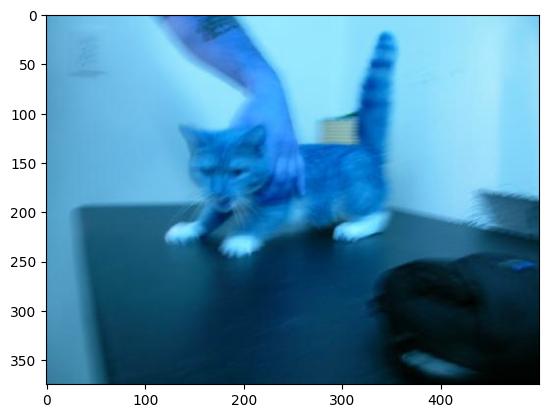

In [8]:
#Visualizing an image
img = cv2.imread(os.path.join('CatsDogs_Split/train','Cats', '0.jpg'))
plt.imshow(img)
plt.show()

### <span style="color: LightSalmon;"> *1.3 Loading & Exploring The Dataset:* </span>

In [6]:
#Building an image dataset on the fly, no need to build the labels, the classes. 
#Note: this will resize the images to 64x64.
#Images will be shuffled as well.
data = tf.keras.utils.image_dataset_from_directory('CatsDogs_Split/train', image_size=(64,64))

Found 19785 files belonging to 2 classes.


In [8]:
#This will allow us to access the generator from our data pipeline
data_iterator = data.as_numpy_iterator()

In [9]:
#Get another batch from the iterator
batch = data_iterator.next()

In [12]:
len(batch)

2

- There are 2 parts of the dataset:
    - The actual dataset images stored as numpy arrays
    - labels

In [12]:
batch[0].shape

(32, 64, 64, 3)

- Batch size is 32, image size is 256 by 256 by 3 channels

In [13]:
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0])

- Labels are either 0 or 1, meaning Cat or Dog.

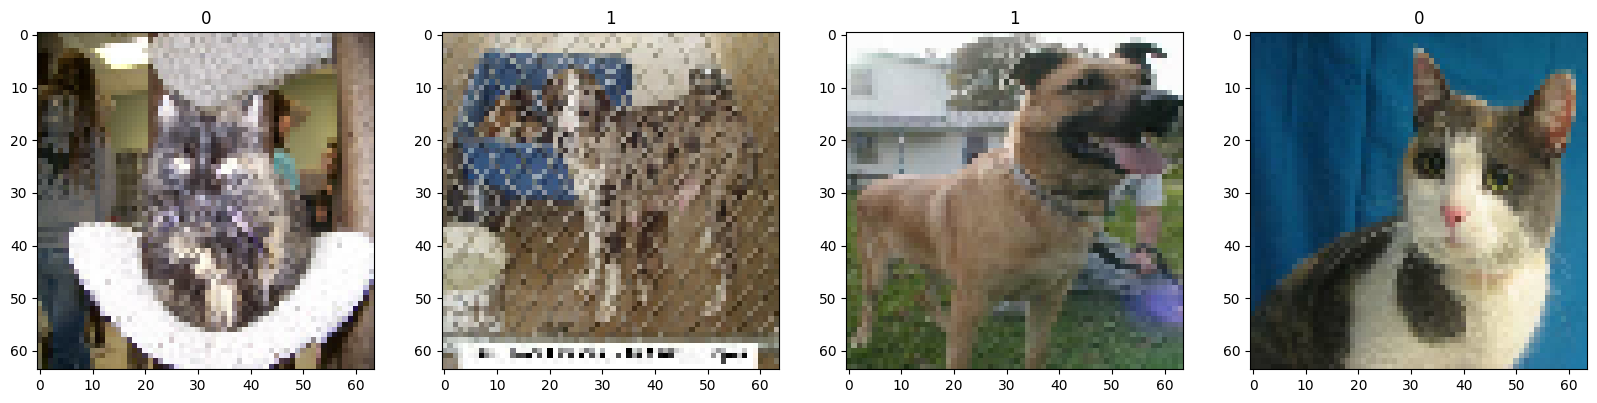

In [10]:
#Plotting the images to determine which value means Cat and which value means Dog
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

- From the above plot, we can determine that label 1 means dog and label 0 means cat.

## <span style="color: IndianRed;"> 2. The Deep Learning Model </span>

### <span style="color: LightSalmon;"> *2.1 Building The Model:* </span>

In [45]:
def cnn_model():    
    model = Sequential()
    #Resizing the images
    model.add(Resizing(100,100))
    #- Scaling the image values between 0 & 1 instead of 0 to 255. This will help our Deep learning model to optimize faster and produce better results.
    model.add(Rescaling(1./255))
    #Data Augmentation to prevent overfitting
    model.add(RandomFlip('horizontal'))
    model.add(RandomRotation(0.2))
    model.add(RandomZoom(0.2))
    
    #Adding a convolutional layer and a MaxPooling layer
    #Each filter is going to be 3x3 in size and we are moving by 1 step/stride each time
    #Activation is going to be Rectified Linear Unit(relu), meaning any output below zero is going to be equal 0 and any other positive value is going to be preserved
    #MaxPooling helps us condense the information we get after the activation with the aim of getting the maximum values
    #MaxPooling halves the output of the Convolutional layer

    #First Layer
    model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    #Second Layer
    model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    #Third Layer
    model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Dropout(0.2))

    #We have condensed the rows and the width and the number of filters will form the channel value
    #Now the aim when flattening the data is condense the channel value to a single value
    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    #Now we are condensing them even more to get the final value (0 or 1 --> cat or dog)
    model.add(Dense(1, activation = 'sigmoid'))

    #List of optimizers can be checked --> (tf.optimizers.)
    model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

    return model

### <span style="color: LightSalmon;"> *2.2 Splitting The Data:* </span>

In [15]:
splitfolders.ratio(Train_dir, output='train_val_split', seed= np.random.randint(1,1000,1)[0], ratio = (0.8, 0.2))

### <span style="color: LightSalmon;"> *2.3 Fitting The Model:* </span>

In [46]:
def fit_model(tr, val):
    model = None
    model = cnn_model()

    #fitting the model
    hist = model.fit(tr, validation_data = val, epochs=25, verbose = 1, callbacks = [ReduceLROnPlateau()])
    
    #Saving our model
    model.save("Trials/100x100_3layers_stride1")
    return hist

### <span style="color: LightSalmon;"> *2.4 Training The Model & Visualizing Average Scores:* </span>

In [47]:
train_data = tf.keras.utils.image_dataset_from_directory('train_val_split/train', image_size = (100,100))
val_data = tf.keras.utils.image_dataset_from_directory('train_val_split/val', image_size = (100,100))
hist = fit_model(train_data, val_data)
print("======="*10, end="\n\n\n")

Found 15827 files belonging to 2 classes.
Found 3958 files belonging to 2 classes.
Epoch 1/25
495/495 [==============================] - 212s 422ms/step - loss: 0.6683 - accuracy: 0.5831 - val_loss: 0.6227 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 2/25
495/495 [==============================] - 212s 428ms/step - loss: 0.6143 - accuracy: 0.6668 - val_loss: 0.5562 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 3/25
495/495 [==============================] - 208s 420ms/step - loss: 0.5797 - accuracy: 0.6984 - val_loss: 0.5267 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 4/25
495/495 [==============================] - 196s 395ms/step - loss: 0.5576 - accuracy: 0.7153 - val_loss: 0.5029 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 5/25
495/495 [==============================] - 215s 434ms/step - loss: 0.5367 - accuracy: 0.7315 - val_loss: 0.4948 - val_accuracy: 0.7587 - lr: 0.0010
Epoch 6/25
495/495 [==============================] - 217s 438ms/step - loss: 0.5192 - accuracy: 0.7450 - val_loss: 0.5087

In [48]:
model = load_model('Trials/100x100_3layers_stride1')

In [49]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 100, 100, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 100, 100, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 100, 100, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 98, 98, 32)        896       
                                                      

### <span style="color: LightSalmon;"> *2.5 Plotting Model's Performance:* </span>

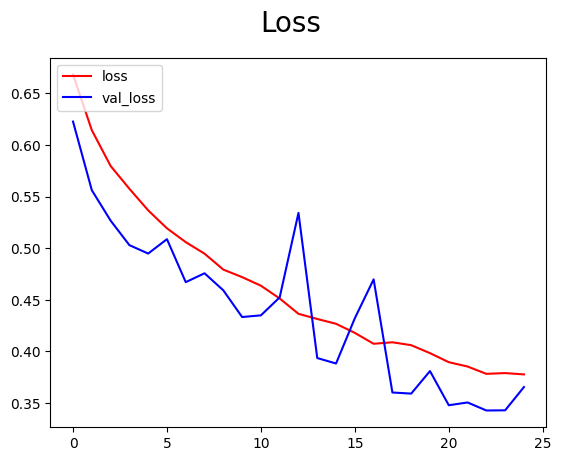

In [50]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

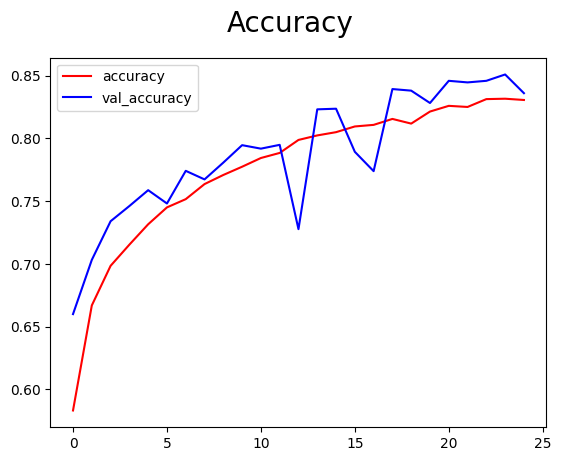

In [51]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

## <span style="color: IndianRed;"> 3. Evaluating Model's Performance </span>

### <span style="color: LightSalmon;"> *3.1 Evaluate The Model:* </span>

In [177]:
model = load_model('Trials/100x100_3layers_stride1')

In [ ]:
#Visualizing model's summary:
model.summary()

In [178]:
test = tf.keras.utils.image_dataset_from_directory('CatsDogs_Split/test', image_size=(100,100))

Found 4947 files belonging to 2 classes.


In [179]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [180]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 102ms/step


In [115]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8587548732757568, Recall:0.8935222625732422, Accuracy:0.8734586834907532
